# Semi-supervised learning with VAEs

In [1]:
%matplotlib inline

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import pickle
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
# Get MNIST dataset
mnist = input_data.read_data_sets('data', one_hot=True)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
class DataSet():
    
    def __init__(self, labels, images):
        self.labels = labels
        self.images = images
        self.num_examples = self.labels.shape[0]
        self.index_in_epoch = 0
        self.epochs_completed = 0
        
    def next_batch(self, batch_size):
        image_batch = np.zeros((batch_size, *self.images.shape[1:]))
        labels_batch = np.zeros((batch_size, *self.labels.shape[1:]))
        for i in range(batch_size):
            image_batch[i,:] = self.images[self.index_in_epoch,:]
            labels_batch[i,:] = self.labels[self.index_in_epoch,:]
            self.index_in_epoch = (self.index_in_epoch + 1) % self.num_examples
            if self.index_in_epoch == 0:
                self.epochs_completed += 1
        return [image_batch, labels_batch]

In [4]:
# Split train set in labelled and unlabelled sets
labelled_samples = 10000
train_labelled = DataSet(mnist.train.labels[:labelled_samples], mnist.train.images[:labelled_samples])
train_unlabelled = DataSet(mnist.train.labels[labelled_samples:], mnist.train.images[labelled_samples:])

print(train_labelled.num_examples, train_unlabelled.num_examples)

10000 45000


In [7]:
# Create the model
class CVAE():
    
    def __init__(self, io_size, z_dim, nclasses, hidden_size, build=True):
        # sizes
        self.io_size = io_size
        self.z_dim = z_dim
        self.nclasses = nclasses
        self.hidden_size = hidden_size
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()            
            
    def placeholders(self):
        self.enc_input = tf.placeholder(tf.float32, shape=[None, self.io_size], name='enc_input')
        self.output = tf.placeholder(tf.float32, shape=[None, self.io_size], name='output')
        self.dec_mu_input = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='dec_input')
        self.dec_sigma_input = tf.placeholder(tf.float32, shape=[None, self.z_dim], name='dec_input')
        self.labels = tf.placeholder(tf.float32, shape=[None, self.nclasses], name='labels')
        
    def encoder(self, enc_input, reuse=False):
        with tf.variable_scope('encoder', reuse=reuse):
            # Znet layers
            layer = tf.contrib.layers.flatten(enc_input)
            layer = tf.contrib.layers.fully_connected(layer, self.hidden_size, activation_fn=tf.nn.relu)
            mu = tf.contrib.layers.fully_connected(layer, self.z_dim, activation_fn=None)
            log_sigma = tf.contrib.layers.fully_connected(layer, self.z_dim, activation_fn=None)
            ylogits = tf.contrib.layers.fully_connected(layer, self.nclasses, activation_fn=None)
            y = tf.nn.softmax(ylogits)
            
            return mu, log_sigma, ylogits, y
            
    def decoder(self, mu, log_sigma, reuse=False): 
        with tf.variable_scope('decoder', reuse=reuse):
            batch_size = tf.shape(mu)[0]
            z = tf.random_normal([batch_size, self.z_dim], mu, tf.exp(log_sigma))
            # Decoder layers
            layer = tf.contrib.layers.fully_connected(z, self.hidden_size, activation_fn=tf.nn.relu)        
            logits = tf.contrib.layers.fully_connected(layer, self.io_size*self.nclasses, activation_fn=None)
            logits = tf.reshape(logits, [-1, self.nclasses, self.io_size]) # adjacent outputs form an image ;)
            
            return logits
            
    def build(self):
        self.placeholders()
        
        mu, log_sigma, qy_x_logits, qy_x = self.encoder(self.enc_input)
        self.logits = self.decoder(mu, log_sigma)
        self.sampled_logits = self.decoder(self.dec_mu_input, self.dec_sigma_input, reuse=True)
        
        ## Loss functions
        # KL (q(z|x) || p(z))
        kl = 0.5 * tf.reduce_sum(tf.exp(log_sigma) + tf.square(mu) - 1. - log_sigma, axis=1)
        # H (q(y|x))
        # Hq = -tf.reduce_sum(qy_x * tf.log(qy_x), axis=1) # numerically unstable
        max_logit = tf.reduce_max(qy_x_logits, axis=1, keep_dims=True)
        max_logits = tf.tile(max_logit, (1, self.nclasses))
        sum_logits = tf.log(tf.reduce_sum(tf.exp(qy_x_logits - max_logits), axis=1, keep_dims=True))
        sum_logits = tf.tile(sum_logits, (1, self.nclasses))
        logq = qy_x_logits - max_logits - sum_logits
        Hq = -tf.reduce_sum(qy_x * logq, axis=1)
        # classification
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=qy_x_logits, labels=self.labels)
        # reconstruction
        output = tf.tile(self.output, [1, self.nclasses])
        output = tf.reshape(output, [-1, self.nclasses, self.io_size])
        logp = tf.reduce_sum(
                        tf.nn.sigmoid_cross_entropy_with_logits(logits=self.logits, labels=output), 
                        axis=2)
        logp = tf.squeeze(logp)
        # Labelled
        logp_labelled = tf.reduce_sum(logp * self.labels, axis=1)
        self.loss_labelled = tf.reduce_mean(logp_labelled + kl + cross_entropy)
        # Unlabelled
        logp_unlabelled = tf.reduce_sum(logp * qy_x, axis=1)
        self.loss_unlabelled = tf.reduce_mean(logp_unlabelled + kl  + Hq)
        # Supervised learning
        self.loss_supervised = tf.reduce_mean(cross_entropy)
        # Accuracy
        correct_prediction = tf.equal(tf.argmax(self.labels, 1), tf.argmax(qy_x_logits, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        # Optimizer
        self.train_labelled = tf.train.AdamOptimizer(1e-4).minimize(self.loss_labelled)
        self.train_unlabelled = tf.train.AdamOptimizer(1e-4).minimize(self.loss_unlabelled)
        self.train_supervised = tf.train.AdamOptimizer(1e-4).minimize(self.loss_supervised)
      
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name    
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)            
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            try:
                self.__dict__[k] =  graph.get_tensor_by_name(n)
            except:
                try:
                    self.__dict__[k] =  graph.get_operation_by_name(n)
                except:
                    raise
 

In [8]:
# Train the model and save it
io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10
batch_size = 32
nepochs = 50
restore_vae = False # False, True

tf.reset_default_graph()
if restore_vae:    
    vae = CVAE(io_size, z_dim, nclasses, hidden_size, build=False)    
else:
    vae = CVAE(io_size, z_dim, nclasses, hidden_size)
    with open('chck/gc.pickle', 'wb') as f:
        pickle.dump(vae.gc, f)
        
with tf.Session() as sess:
    if restore_vae:
        saver = tf.train.import_meta_graph('chck/vae.meta')
        saver.restore(sess, "chck/vae")
        with open('chck/gc.pickle', 'rb') as f:
            gc = pickle.load(f) 
        vae.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = mnist.train.num_examples + mnist.validation.num_examples
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        labelled_loss, unlabelled_loss, valid_acc = 0, 0, 0.0
        for epoch in range(nepochs):
            # Labelled
            for batch_idx in range(int(train_labelled.num_examples//batch_size)):
                batch = train_labelled.next_batch(batch_size)
                _, labelled_loss, accuracy = sess.run([vae.train_labelled, vae.loss_labelled, vae.accuracy], 
                                feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(LL='{:.3f}'.format(labelled_loss), \
                                 UL='{:.3f}'.format(unlabelled_loss), \
                                 acc='{:.2f}'.format(accuracy), \
                                 vacc='{:.2f}'.format(valid_acc))
            # Unlabelled
            for batch_idx in range(int(train_unlabelled.num_examples//batch_size)):
                batch = train_unlabelled.next_batch(batch_size)
                _, unlabelled_loss, accuracy = sess.run([vae.train_unlabelled, vae.loss_unlabelled, vae.accuracy], 
                                feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(LL='{:.3f}'.format(labelled_loss), \
                                 UL='{:.3f}'.format(unlabelled_loss), \
                                 acc='{:.2f}'.format(accuracy), \
                                 vacc='{:.2f}'.format(valid_acc))

            # Validation accuracy
            for batch_idx in range(int(mnist.validation.num_examples//batch_size)):
                batch = mnist.validation.next_batch(batch_size)
                acc = sess.run(vae.accuracy, 
                            feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                valid_acc = (valid_acc*batch_idx + acc)/(batch_idx + 1)
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(LL='{:.3f}'.format(labelled_loss), \
                                 UL='{:.3f}'.format(unlabelled_loss), \
                                 acc='{:.2f}'.format(accuracy), \
                                 vacc='{:.2f}'.format(valid_acc))
                
    save_path = saver.save(sess, "chck/vae")

Epoch 50: 100%|█████████▉| 2998400/3000000 [11:28<00:00, 4357.50 examples/s, LL=122.200, UL=112.233, acc=0.94, vacc=0.91]


In [9]:
# Test model
io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10
batch_size = 32

tf.reset_default_graph()
vae = CVAE(io_size, z_dim, nclasses, hidden_size, build=False)    
   
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/vae.meta')
    saver.restore(sess, "chck/vae")
    with open('chck/gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    vae.init_from_graph(sess.graph, gc)

    with tqdm(desc='Epoch', total=mnist.test.num_examples, unit=' examples') as pbar:
        test_acc = 0.0
        for batch_idx in range(int(mnist.test.num_examples//batch_size)):
            batch = mnist.validation.next_batch(batch_size)
            acc = sess.run(vae.accuracy, 
                        feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
            test_acc = (test_acc*batch_idx + acc)/(batch_idx + 1)
            pbar.set_description('Epoch {:2}'.format(epoch+1))
            pbar.update(batch_size)
            
    print('Test accuracy {:.2f}'.format(test_acc))

INFO:tensorflow:Restoring parameters from chck/vae


Epoch 50: 100%|█████████▉| 9984/10000 [00:00<00:00, 43156.43 examples/s]

Test accuracy 0.91


## Display reconstituted images

INFO:tensorflow:Restoring parameters from chck/vae


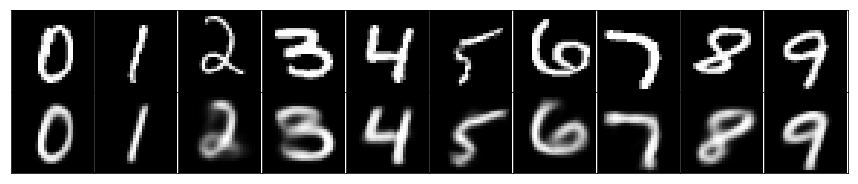

In [10]:
# Display input/output pairs
io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10

images = {l: {'original': np.zeros((28,28)), 'reconstituted': np.zeros((28,28))} for l in range(10)}

found = [False for _ in range(10)]
for im, label in zip(mnist.test.images, mnist.test.labels):
    l = np.int(np.squeeze(np.where(label==1)))
    images[l]['original'] = np.reshape(im, (28, 28))
    found[l] = True
    if all(found):
        break

tf.reset_default_graph()
vae = CVAE(io_size, z_dim, nclasses, hidden_size, build=False)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/vae.meta')
    saver.restore(sess, "chck/vae")
    with open('chck/gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    vae.init_from_graph(sess.graph, gc)
    
    with tf.variable_scope('reconstitute'):
        pix = tf.nn.sigmoid(vae.logits)
        labels = tf.expand_dims(vae.labels, -1)
        reconstituted = tf.multiply(pix, labels)
        reconstituted = tf.reduce_sum(reconstituted, axis=1)        

    v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='reconstitute')
    sess.run(tf.variables_initializer(v))        
        
    for l in range(10):
        img = np.reshape(images[l]['original'], 784)
        label = np.zeros((1, nclasses))
        label[0, l] = 1
        recon = sess.run(reconstituted, 
                feed_dict={vae.enc_input: img[np.newaxis,:], vae.labels: label})
        images[l]['reconstituted'] = np.reshape(recon, (28, 28))

fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(1.5*10,2*1.5))
for ii in range(10):
    axes[0][ii].imshow(images[ii]['original'], aspect='equal', cmap='gray')
    axes[0][ii].xaxis.set_visible(False)
    axes[0][ii].yaxis.set_visible(False)
    axes[1][ii].imshow(images[ii]['reconstituted'], aspect='equal', cmap='gray')
    axes[1][ii].xaxis.set_visible(False)
    axes[1][ii].yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

## Generate samples 

INFO:tensorflow:Restoring parameters from chck/vae


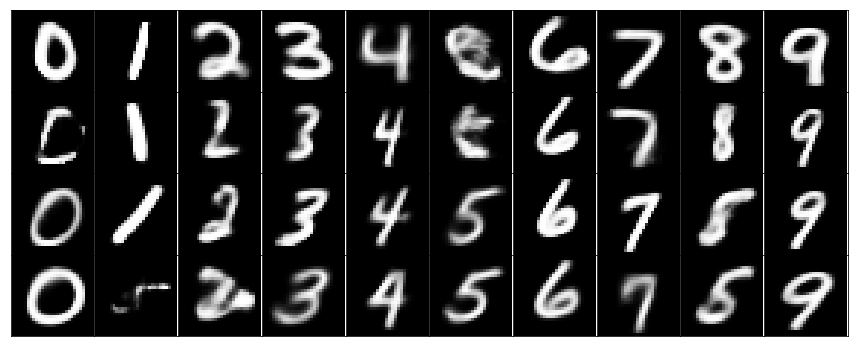

In [11]:
io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10
vsamples = 4

tf.reset_default_graph()
vae = CVAE(io_size, z_dim, nclasses, hidden_size, build=False)


'''for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder'):
    print(v.name)

logits = vae.decoder(vae.dec_mu_input, vae.dec_sigma_input, reuse=True)
print('----')
for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder'):
    print(v.name)
print('----')
print(vae.dec_mu_input.name)
print(vae.dec_sigma_input.name)
print(vae.labels.name) '''   
    
with tf.Session() as sess:
    saver = tf.train.import_meta_graph('chck/vae.meta')
    with open('chck/gc.pickle', 'rb') as f:
        gc = pickle.load(f) 
    vae.init_from_graph(sess.graph, gc)    
    saver.restore(sess, "chck/vae")    
    
    mu = np.random.normal(0.0, 1.0, (vsamples, vae.z_dim))
    log_sigma = np.random.normal(0.0, 1.0, (vsamples, vae.z_dim))
    mu = np.repeat(mu, nclasses, axis=0)
    log_sigma = np.repeat(log_sigma, nclasses, axis=0)
    labels = np.eye(nclasses)
    labels = np.tile(labels, (vsamples, 1))
        
    with tf.variable_scope('sample'):        
        reconstituted = tf.nn.sigmoid(vae.sampled_logits)
        reconstituted = tf.multiply(reconstituted, tf.expand_dims(vae.labels, axis=-1))
        reconstituted = tf.reduce_sum(reconstituted, axis=1)
        
    v = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='sample')
    sess.run(tf.variables_initializer(v))
    
    samples = sess.run(reconstituted, 
                       feed_dict={vae.dec_mu_input: mu, vae.dec_sigma_input: log_sigma, vae.labels: labels})

fig, axes = plt.subplots(vsamples, nclasses, sharex=True, sharey=True, figsize=(1.5*nclasses,1.5*vsamples))
for ih in range(nclasses):
    for iv in range(vsamples):
        img = np.reshape(samples[ih+iv*nclasses,:], (28, 28))
        axes[iv][ih].imshow(img, aspect='equal', cmap='gray')
        axes[iv][ih].xaxis.set_visible(False)
        axes[iv][ih].yaxis.set_visible(False)
        
plt.subplots_adjust(wspace=0, hspace=0) 

  ## Compare supervised to semi-supervised learning

### Supervised learning



In [ ]:
# Function to gather accuracy statistics
def acchist(train_split, nepochs=1, training='supervised'):
    assert train_split >= 0.0, "train_split must be >= 0.0, {} given".format(train_split)
    assert train_split <= 1.0, "train_split must be <= 1.0, {} given".format(train_split)
    # split train data in labelled and unlabelled sets
    num_samples = int(mnist.train.num_examples*train_split)
    train_supervised = DataSet(mnist.train.labels[:num_samples], mnist.train.images[:num_samples])
    # statistic lists
    train_acc, valid_acc, test_acc = [], [], []
    # network configuration constants
    io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10
    batch_size = 32
    # create network
    tf.reset_default_graph()
    vae = CVAE(io_size, z_dim, nclasses, hidden_size)
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        if training == 'supervised':
            num_examples = train_supervised.num_examples + mnist.validation.num_examples + mnist.test.num_examples
        else:
            num_examples = mnist.train.num_examples + mnist.validation.num_examples + mnist.test.num_examples
        with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
            for epoch in range(nepochs):
                acc = 0.0
                if training == 'supervised':
                    # Supervised
                    for batch_idx in range(int(train_supervised.num_examples//batch_size)):
                        batch = train_supervised.next_batch(batch_size)
                        _, supervised_loss, batch_acc = \
                                sess.run([vae.train_supervised, vae.loss_supervised, vae.accuracy], 
                                        feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                        acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                        pbar.set_description('Epoch {:2}'.format(epoch+1))
                        pbar.update(batch_size)
                else:
                    for batch_idx in range(int(train_labelled.num_examples//batch_size)):
                        batch = train_labelled.next_batch(batch_size)
                        _, labelled_loss, batch_acc = \
                                sess.run([vae.train_labelled, vae.loss_labelled, vae.accuracy], 
                                    feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                        acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                        pbar.set_description('Epoch {:2}'.format(epoch+1))
                        pbar.update(batch_size)
                    n_labelled_batches = batch_idx

                    # Unlabelled
                    for batch_idx in range(int(train_unlabelled.num_examples//batch_size)):
                        batch = train_unlabelled.next_batch(batch_size)
                        _, unlabelled_loss, batch_acc = \
                                sess.run([vae.train_unlabelled, vae.loss_unlabelled, vae.accuracy], 
                                    feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                        train_batch_idx = batch_idx + n_labelled_batches + 1
                        acc = (acc*train_batch_idx + batch_acc)/(train_batch_idx + 1)
                        pbar.set_description('Epoch {:2}'.format(epoch+1))
                        pbar.update(batch_size)
                train_acc.append(acc) 

                # Validation accuracy
                acc = 0.0
                for batch_idx in range(int(mnist.validation.num_examples//batch_size)):
                    batch = mnist.validation.next_batch(batch_size)
                    batch_acc = sess.run(vae.accuracy, 
                            feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                    acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                valid_acc.append(acc)
                    
                # Test accuracy
                acc = 0.0
                for batch_idx in range(int(mnist.test.num_examples//batch_size)):
                    batch = mnist.validation.next_batch(batch_size)
                    batch_acc = sess.run(vae.accuracy, 
                            feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                    acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                test_acc.append(acc)
                
    return train_acc, valid_acc, test_acc

In [ ]:
supervised_stats = dict()
for train_split in [0.25, 0.5, 0.75, 1.0]:#[0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    train_acc, valid_acc, test_acc = acchist(train_split=train_split, nepochs=50, training='supervised')
    supervised_stats[train_split] = {'train': train_acc, 'valid': valid_acc, 'test': test_acc}

with open('chck/supervised_stats.pickle', 'wb') as f:
    pickle.dump(supervised_stats, f)

### Semi-supervised learning

In [ ]:
semisupervised_stats = dict()
for train_split in [0.25, 0.5, 0.75, 1.0]:#[0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    train_acc, valid_acc, test_acc = acchist(train_split=train_split, nepochs=50, training='semisupervised')
    semisupervised_stats[train_split] = {'train': train_acc, 'valid': valid_acc, 'test': test_acc}

with open('chck/semisupervised_stats.pickle', 'wb') as f:
    pickle.dump(semisupervised_stats, f)

### Plot supervised & semi-supervised learning comparison

In [ ]:
with open('chck/supervised_stats.pickle', 'rb') as f:
    supervised_stats = pickle.load(f)

with open('chck/semisupervised_stats.pickle', 'rb') as f:
    semisupervised_stats = pickle.load(f)    
    
nsplits=len(supervised_stats)
fig, axes = plt.subplots((nsplits+1)//2, 2, figsize=(8.0*2,nsplits*4.0/2))
for ii, split in enumerate(sorted(supervised_stats.keys())):
    axes[ii//2][ii%2].plot(supervised_stats[split]['test'], 'g', label='supervised' + ' {:.2f}'.format(split))
    axes[ii//2][ii%2].plot(semisupervised_stats[split]['test'], 'b--', label='semi-supervised' + ' {:.2f}'.format(split))
    axes[ii//2][ii%2].set_title('{:.2f}'.format(split))
    axes[ii//2][ii%2].set_xlim(-0.5, 50.5)
    axes[ii//2][ii%2].set_ylim(0.0, 1.0)
    axes[ii//2][ii%2].grid()
    axes[ii//2][ii%2].legend(loc="lower right")


In [ ]:
with open('chck/supervised_stats.pickle', 'rb') as f:
    supervised_stats = pickle.load(f)
    
stylez=['g--', 'b--', 'g*', 'b*']

fig, axes = plt.subplots(1, 1, figsize=(8.0,4.0))
for ii, split in enumerate(sorted(supervised_stats.keys())):
    axes.plot(supervised_stats[split]['test'], stylez[ii], label='supervised' + ' {:.2f}'.format(split))

axes.set_title('Supervised training on a subset')
axes.set_xlim(-0.5, 50.5)
axes.set_ylim(0.88, 0.99)
axes.grid()
axes.legend(loc="lower right")


**&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;**

**&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;**

## _Old discarded code_

**&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;**

**&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;
&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;&#9830;**


In [ ]:
# Function to gather accuracy statistics
def acchist(train_split, nepochs=1):
    assert train_split > 0.0, "train_split must be > 0.0, {} given".format(train_split)
    assert train_split < 1.0, "train_split must be < 1.0, {} given".format(train_split)
    # split train data in labelled and unlabelled sets
    labelled_samples = int(mnist.train.num_examples*train_split)
    train_labelled = DataSet(mnist.train.labels[:labelled_samples], mnist.train.images[:labelled_samples])
    train_unlabelled = DataSet(mnist.train.labels[labelled_samples:], mnist.train.images[labelled_samples:])
    # statistic lists
    train_acc, valid_acc, test_acc = [], [], []
    # network configuration constants
    io_size, z_dim, hidden_size, nclasses = 784, 4, 512, 10
    batch_size = 32
    # create network
    tf.reset_default_graph()
    vae = CVAE(io_size, z_dim, nclasses, hidden_size)
   
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        num_examples = mnist.train.num_examples + mnist.validation.num_examples + mnist.test.num_examples
        with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
            for epoch in range(nepochs):
                acc = 0.0
                # Labelled
                for batch_idx in range(int(train_labelled.num_examples//batch_size)):
                    batch = train_labelled.next_batch(batch_size)
                    _, labelled_loss, batch_acc = sess.run([vae.train_labelled, vae.loss_labelled, vae.accuracy], 
                                feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                    acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                n_labelled_batches = batch_idx
                
                # Unlabelled
                for batch_idx in range(int(train_unlabelled.num_examples//batch_size)):
                    batch = train_unlabelled.next_batch(batch_size)
                    _, unlabelled_loss, batch_acc = sess.run([vae.train_unlabelled, vae.loss_unlabelled, vae.accuracy], 
                                feed_dict={vae.enc_input: batch[0], vae.output: batch[0], vae.labels: batch[1]})
                    train_batch_idx = batch_idx + n_labelled_batches + 1
                    acc = (acc*train_batch_idx + batch_acc)/(train_batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                train_acc.append(acc)

                # Validation accuracy
                acc = 0.0
                for batch_idx in range(int(mnist.validation.num_examples//batch_size)):
                    batch = mnist.validation.next_batch(batch_size)
                    batch_acc = sess.run(vae.accuracy, 
                            feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                    acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                valid_acc.append(acc)
                    
                # Test accuracy
                acc = 0.0
                for batch_idx in range(int(mnist.test.num_examples//batch_size)):
                    batch = mnist.validation.next_batch(batch_size)
                    batch_acc = sess.run(vae.accuracy, 
                            feed_dict={vae.enc_input: batch[0], vae.labels: batch[1]})
                    acc = (acc*batch_idx + batch_acc)/(batch_idx + 1)
                    pbar.set_description('Epoch {:2}'.format(epoch+1))
                    pbar.update(batch_size)
                test_acc.append(acc)
                
    return train_acc, valid_acc, test_acc

In [ ]:
stats = dict()
for train_split in [0.25, 0.5, 0.75, 1.0]:#[0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
    train_acc, valid_acc, test_acc = acchist(train_split=train_split, nepochs=50)
    stats[train_split] = {'train': train_acc, 'valid': valid_acc, 'test': test_acc}

with open('chck/stats.pickle', 'wb') as f:
    pickle.dump(stats, f)

In [ ]:
with open('chck/stats.pickle', 'rb') as f:
    stats = pickle.load(f)
    
nsplits=len(stats)
fig, axes = plt.subplots((nsplits+1)//2, 2, figsize=(8.0*2,nsplits*4.0/2))
for ii, split in enumerate(sorted(stats.keys())):
    axes[ii//2][ii%2].plot(stats[split]['train'], 'r')
    axes[ii//2][ii%2].plot(stats[split]['valid'], 'g')
    axes[ii//2][ii%2].plot(stats[split]['test'], 'b')
    axes[ii//2][ii%2].set_title('{:.2f}'.format(split))
    axes[ii//2][ii%2].grid()
    #axes[0][ii].xaxis.set_visible(False)
    #axes[0][ii].yaxis.set_visible(False)
    
#plt.subplots_adjust(wspace=0, hspace=0)